<a href="https://colab.research.google.com/github/khalilkabara/Kaggle-Dog-Breed-Identification/blob/master/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-To-End Multi Class Dog Breed Classification (On Google Colab)

> This project and the entire notebook was built on and is intended to run Google Colab with  GPU config.

> The version of Tensor Flow used for this project is 2.2.0-rc4

> The version of Tensorflow Hub used is 0.8.0

> Other libraries used include numpy, pandas and matplotlib.

> All data will be imported from Google Drive

> A copy of this notebook is hosted on github at https://github.com/khalilkabara/Kaggle-Dog-Breed-Identification/blob/master/Dog_Breed_Identification.ipynb

### 1.0 Workflow

>##### **1.1 Problem Overview**
>**Summary:** Identify the breed of a dog given it's image

>In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

>This problem was hosted on Kaggle at https://www.kaggle.com/c/dog-breed-identification/

>##### **1.2 Data**
>You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

>More at: https://www.kaggle.com/c/dog-breed-identification/data

>##### **1.3 Modelling**
>For this peoject, we are going to use Google's Tensorflow

>##### **1.4 Evaluation**
>Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

>Submission File: For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

>id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

>**Multi-Class-Log-Loss:** Multi-class logarithmic loss function per class. ... The cost function F measures the distance between two probability distributions, i.e. how similar is the distribution of actual labels and classifier probabilities. Hence, values close to zero are preferred. More at https://stats.stackexchange.com/questions/113301/multi-class-logarithmic-loss-function-per-class

>More at: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


>##### **1.5 Features**
>You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

>More at: https://www.kaggle.com/c/dog-breed-identification/data

## 2.0 Import Libraries And Get Workspace Ready
> Import TensorFlow into colab

> Ensure we are running TF v 2.0 and above

> Import Tensorflow Hub

> Ensure we are running on a GPU

In [0]:
# Import TensorFlow into colab

import tensorflow as tf

In [2]:
# Check TF version

print("TF version: ", tf.__version__)

TF version:  2.2.0


In [3]:
# Import Tensorflow Hub

import tensorflow_hub as hub
print("TF Hub version: ", hub.__version__)

TF Hub version:  0.8.0


In [4]:
# Check if GPU is available

print("GPU", "available." if tf.config.list_physical_devices("GPU") else "not available")

# If GPU not available, so setup GPU in notebook settings under toolbar > runtime > change runtime type

GPU available.


## 3.0 Import Data

>Connect to google drive

>Locte directory containing files

In [0]:
# Import Data Into Colab (Or Use Google Drive As Indicated In The Next Cell)

# !wget -x --load-cookies cookies.txt "https://www.kaggle.com/c/7327/download-all" -O data.zip
# !unzip data.zip

In [0]:
# Authorize Google Drive Mount So That We Can Access Google Drive Data From Colab

from google.colab import drive

def mount_drive():
  drive.mount('/content/drive')

# Uncomment function call to initiate google drive mount, copy authorization token and paste in the text box that appears.
# mount_drive()

In [0]:
# Unzip Files In Google Drive

# !unzip "/content/drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data.zip" -d "/content/drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped"

## 4.0 Get Data Ready
>Turn data into tensors for use with Tensorflow

>**NOTE:** We have stored all data in google drive. Alter path_to_files variable to point to the drive location where you have stored your data

### 4.1 Create Helper Strings And Import Pandas

In [0]:
# Create Helper Strings That Point To File Paths Since Paths Are Pretty Long

path_to_files = "drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/"

test_data_path = path_to_files + "test/"
train_data_path = path_to_files + "train/"
labels_path = path_to_files + "labels.csv"
sample_submission_path = path_to_files + "sample_submission.csv"

In [0]:
# Import Pandas

import pandas as pd

### 4.2 Get And Explore Labels Data

In [10]:
# Check out data labels

labels_csv = pd.read_csv(labels_path)
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
# Describe labels

labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,1c80cbd184334b339e5eba8aaa6ae929,scottish_deerhound
freq,1,126


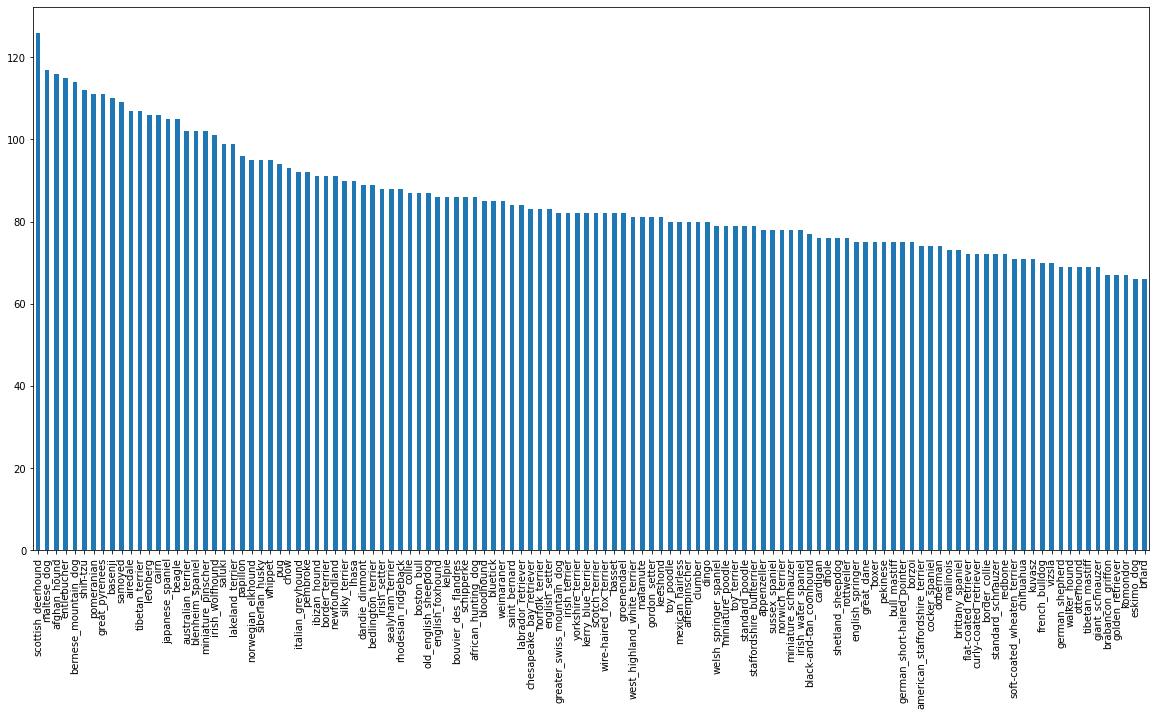

In [12]:
# Visuaize the different breeds that are in our data

labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10));

### 4.3 Get And Explore Images Data

In [13]:
# check if number of labels matches number of filenames

import os

filenames = [train_data_path + fname + ".jpg" for fname in labels_csv['id']]

if len(os.listdir(train_data_path)) == len(filenames):
  print("Number of labels matches number of files. You may proceed")
else:
  print("Filenames do NOT match number of files in directory. Check data directories before proceeding")

Number of labels matches number of files. You may proceed


In [0]:
# View an image
# Create a handy function for viewing images given image id's

from IPython.display import Image

def view_image_by_id(image_id, directory='train'):
  """
  A handy function for viewing dog image files in our notebook. Expects image_id
  """
  if directory == 'test':
    return Image(test_data_path + image_id + ".jpg")
  else:
    return Image(train_data_path + image_id + ".jpg")

In [0]:
# Create another function for viewing train data images given an index

def view_image_by_index(index=0):
  if index <= len(filenames):
    return Image(filenames[index])
  else:
    print(f"There is no Image at index {index}. Returning first image")
    return Image(filenames[0])

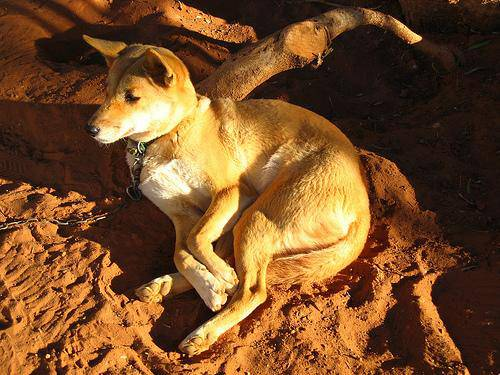

In [16]:
# View a dog image by id

view_image_by_id("001513dfcb2ffafc82cccf4d8bbaba97")

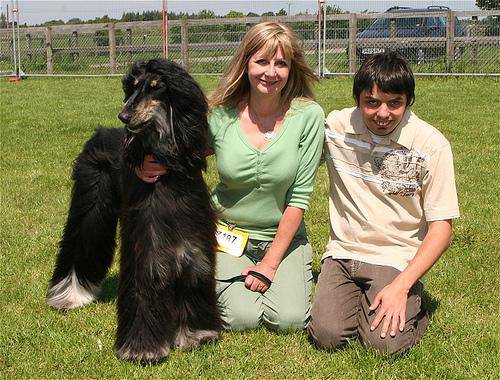

In [17]:
# View a dog image by index (from train data)
view_image_by_index(1200)

### 4.4 Convert Labels Into Numeric Values Using Numpy

In [18]:
# Convert labels into numbers

import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [19]:
# check if number of labels matches number of filenames

if len(labels) == len(filenames):
  print("Number of labels matches number of files. You may proceed")
else:
  print("Number of labels do NOT match number of files. Check data directories before proceeding")

Number of labels matches number of files. You may proceed


In [20]:
# Find the unique label values. Print first 20

unique_breeds = np.unique(labels)
unique_breeds[:20]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull'], dtype=object)

In [21]:
#Turn every label into a boolean array. View only first otwo

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
# One hot encode boolean arrays into integers

### 4.5 Split Training Data into Train And Valid Dataset
Since the dataset from kaggle does not come with a validation set, we are going to create our's.

We are goint to start off experimenting with 1000 images and increase as needed.

In [0]:
# Set up x and y variables

x = filenames
y = boolean_labels

In [0]:
# Set number of images to use for experimenting

NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000, step: 1000}

In [25]:
# Split data into train and validation using train_test_split

from sklearn.model_selection import train_test_split

# Do split into training and validation sets of total size equals to NUM_IMAGES

x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES], 
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2, 
                                                  random_state=42)
len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

### 4.6 Convert Image Data Into Tensors (Numeric Representations)

To preprocess our images into tensors, we will write a function which does the following:
> 1. Take an image file path as input.

> 2. Use tensorflow to read the file and save it to a variable, `image`.

> 3. Turn our `image` (a jpg) into Tensors.

> 4. Normalize our image (Convert color channel values from 0 to 255 to a float between 0 and 1)

> 4. Resize `image` to be a shape of (224, 224)

> 5. Return the modified `image`.

Before proceeding, lets see what importing and converting an image into a tensor looks like

In [26]:
# Convert an image into a numpy array

from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [27]:
# Convert an image into a tensor

tf.constant(image)[:1]

<tf.Tensor: shape=(1, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]]], dtype=uint8)>

In [0]:
# First, let's see what converting an image into a tensor looks like

# tensor = tf.io.read_file(filenames[42])
# String too long, uncomment to view
# tensor

In [0]:
# Create a function that converts images into tensors

# Define image size. We use 224 because the model we are going to use was trained on size (224, 224)
IMAGE_SIZE = 224

# Define our function
def image_to_tensor(image_path, image_size=IMAGE_SIZE):
  """
  Takes an image file path and turns it into a tensor
  """
  # Read image file
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numerical tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size of (224, 224)
  image = tf.image.resize(image, size=[image_size, image_size])
  # Return preprocessed image
  return image

In [30]:
# Test our function

image_to_tensor(filenames[42])[:2]

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]]], dtype=float32)>

### 4.7 Turn Our Data Into Batches

TensorFlow works really well with batches.

**Question:** Why turn our data into batches?

**Answer:** Say for example we are trying to process 10,000+ images in one go... They might not all fit into memory. Though very fast, the GPU we are processing data on still has limited memory. That's why we do about 32 images (batch size) at a time. Can be manually adjusted if needed.

In order to use Tensorflow effectively, we need to get our data in the form of tensor tuples which look like this: `(image, label)`

In [0]:
# Create a simple function that return a tuple of image and label

def get_image_and_label(image_path, label):
  """
  Takes an image file path and it's associated label, processes the image (converts into tensors) then returns a tuple of (image, label)
  """
  return image_to_tensor(image_path), label

In [32]:
get_image_and_label(x[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [0]:
# Create a function that turns all data (x and y that can now be returned in tensors) into batches
# Define batch size, 32 for now. Adjustable
BATCH_SIZE = 32 #@param {type: "slider", min: 32, max: 64, step: 8}


In [0]:
# Define function

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and labels (y) pairs.
  It shuffles the data if it's training data, but doesn't for validation data.
  Also accepts test data as input (no labels).
  """
  # If data is test dataset, there won't be labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # Only filepaths, no labels
    # Map to image_to_tensor function
    data_batch = data.map(image_to_tensor).batch(batch_size)
    return data_batch
  # If data is valid dataset, we do not need to shuffle it
  elif valid_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # File paths
                                               tf.constant(y))) # Labels
    # Map to get_image_and_label function
    # Create (image, label) tuples. This also turns the image path into a processed image by calling image_to_tensor
    data = data.map(get_image_and_label)
    # Turn data into batches
    data_batch = data.batch(batch_size)
    return data_batch
  # If data is train dataset
  else:
    print("Creating training data batches...")
    # Turn file paths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # File paths
                                               tf.constant(y))) # Labels
    # Shuffling pathnames and labels before mapping image_to_tensor function is faster than shuffling images after mapping
    data = data.shuffle(buffer_size=len(x))
    # Map to get_image_and_label function
    # Create (image, label) tuples. This also turns the image path into a processed image by calling image_to_tensor
    data = data.map(get_image_and_label)
    # Turn data into batches
    data_batch = data.batch(batch_size)
    return data_batch

In [35]:
# Test function by creating training and validation data batches

train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)
train_data, val_data

Creating training data batches...
Creating valid data batches...


(<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>)

In [36]:
# Explore newly created data batches

train_data.element_spec, val_data.element_spec
# Images shape=(None, 224, 224, 3) means:
# None for batch size (since it's flexible)
# 224 and 224 for width and height respectively
# And 3 color channels (RGB)

# Then labels shape=(None, 120) means:
# None for batch size (since it's flexible)
# And dimension of 120 (Since there are 120 different dog breeds)

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### 4.8 Explore And Visualize Data Batches

In [0]:
# Explore and visualize batches

import math
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def view_databatch_images(images, labels, quantity=25):
  """
  Displays a plot of images and their labels from a data batch.
  Quantity can not be greater than 32 since our batch size is 32
  """
  if quantity > BATCH_SIZE:
    quantity = BATCH_SIZE
    
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through quantity for displaying that amount of images
  for i in range(quantity):
    # Determine num rows
    n_rows = math.ceil(quantity/5) if quantity/5 > 1 else 1
    # Create subplots (max of 5 columns and adequate rows)
    ax = plt.subplot(n_rows,5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [0]:
# Unbatch training data so that it can be visualized with help of our handy function
# Training data will shuffle each time we run this cell because we shuffle our training data each time we process it for adding into batches

train_images, train_labels = next(train_data.as_numpy_iterator())

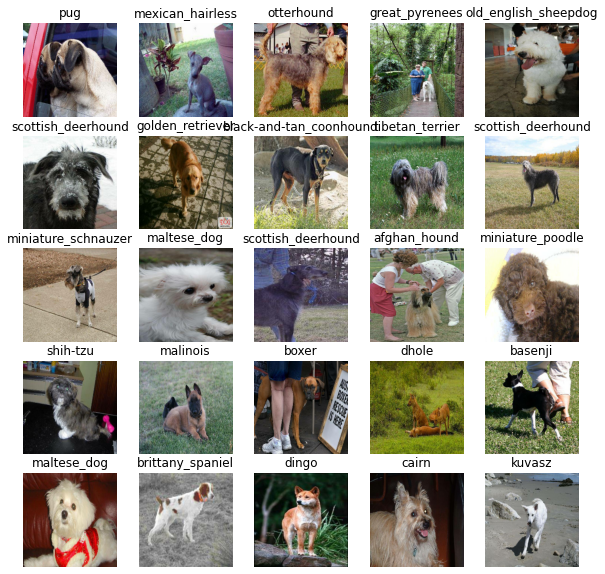

In [39]:
# Visualize data in a training batch

view_databatch_images(train_images, train_labels, 25)

In [0]:
# Unbatch validation data so that it can be visualized with help of our handy function
val_images, val_labels = next(val_data.as_numpy_iterator())

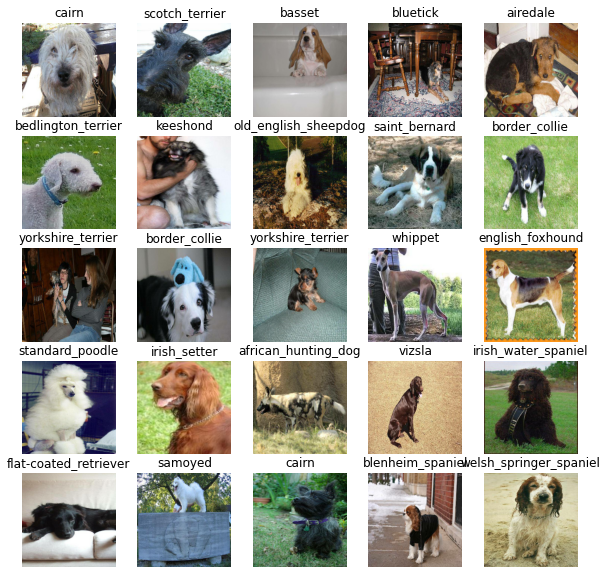

In [41]:
# Visualize data in a validation batch

view_databatch_images(val_images, val_labels, 25)

## 5.0 Modelling

There are several ways to build a deep learning model. For this problem, we will be using transfer learning. We will use an existing model then improve once we have our baseline results.

Before building a model, we need to define the following

* The input shape (our images in the form of tensors)

* The output shape (image labels in the form of tensors)

* The URL of the model we will be using from TensorFlow Hub. (https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4)

### 5.1 Preparing Inputs And Outputs

In [0]:
# Setup input shape
# IMAGE_SIZE is 224 because the model we will be using was trained on images of that size
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, color channels
# Setup output shape
OUTPUT_SHAPE = len(unique_breeds)
# Setup model url from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

#### Create a function that creates a model using TF Keras API (Sequental API since it's easier to implement)

Create a function which:
* Takes the input shape, output shape nd model we've chosen as params.
* Defines the layers in a Keras model in a sequential fashion (one after the other).
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model the inut shape it'll be getting)
* Retuns the model.

More on these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [0]:
# 